# Сравнение моделей детекции на датасете where-are-the-animals

In [3]:
!pip install aim
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 19.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 9.0 MB/s eta 0:00:0000:0100:01mm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 59.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
  Created wheel for aim-ui: filename=aim_ui-3.29.1-py3-none-any.whl size=31195131 sha256=d35d74abf9127cebee274dcd04d303a736232d9bd09e5d040ed474849dd8bdbf
  Stored in directory: /root/.cache/pip/wheels/5c/67/57/0042ea0babc5e4a1359519783813304223c64653c0be9c7d74
Successfully built aim-ui


In [4]:
import random
from pyngrok import ngrok
from IPython.display import Image  # for displaying images
import os 
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
import cv2
import math
from aim import Run

# random.seed(42)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Подготовка данных

In [5]:
dataset_path = "/kaggle/input/where-are-the-animals/data_for_summer"
annotation_path = dataset_path + "/train_split.csv"
image_path = dataset_path + "/train"
img_width = 640
img_height = 480
batch_size = 64
idx2name  = {
    -1: "pad",
    0: "Hare",
    1: "Wild Boar",
    2: "Cats",
    3: "Mustelids",
    4: "Bear",
    5: "Deer family",
    6: "Panthers (Big Cats)",
    7: "Bovids",
    8: "Canids",
    9: "Marmot"
}
name2idx = {v:k for k, v in idx2name.items()}
color2idx = {
    0: (89, 161, 197),
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
    5: (89, 161, 197),
    6: (204, 79, 135),
    7: (125, 216, 93),
    8: (175, 203, 33),
    9: (89, 161, 197)
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
train_split = pd.read_csv(annotation_path)
train_split['stratify_key'] = train_split['detection'].apply(
    lambda x: '_'.join(sorted(set([det.strip().split(' ')[0] for det in x.split(';')])))
)

# Perform stratified split
train_df, test_df = train_test_split(
    train_split, 
    test_size=0.3, 
    random_state=42, 
    stratify=train_split['stratify_key']
)

In [5]:
# Delete after optimization
# train_df = train_df.iloc[:1000]
# test_df = train_df.iloc[:1000]

In [6]:
train_df.head()

image_name  \
1670   486d5b0cf6eb79320e10d61f3270e81f.JPG   
12965  49e071f23b530252e77c11ea50f3c28a.JPG   
7455   c8e1b0f37c2d6bb2fcbbeef35406fe1e.JPG   
16629  6b52cc849ff6a77efdd44c7ca75fb45d.JPG   
7873   50dc8dceae3d9211122435171b72617c.JPG   

                                               detection stratify_key  
1670   5 0.9699900150299072 0.5553755164146423 0.0600...            5  
12965  8 0.883593738079071 0.48585838079452515 0.2328...            8  
7455   5 0.6804317235946655 0.6962481141090393 0.6391...            5  
16629  8 0.5591300129890442 0.7009802460670471 0.0882...            8  
7873   4 0.11243872344493866 0.5619429349899292 0.224...            4

In [10]:
print(f"Train length: {len(train_df)}\nTest length: {len(test_df)}")

Train length: 12363
Test length: 5299


Min bboxes per image: 1
Max bboxes per image: 11
Mean bboxes per image: 1.256


Number of objects per class:
Deer family : 6433
Canids : 1026
Bear : 1408
Panthers (Big Cats) : 2508
Cats : 547
Wild Boar : 1132
Bovids : 1083
Mustelids : 436
Marmot : 417
Hare : 539

Mean bbox size per class (normalized width, height):
Hare : [0.11303266 0.16915789]
Wild Boar : [0.29159197 0.40347653]
Cats : [0.20998412 0.23102143]
Mustelids : [0.1620118  0.15321482]
Bear : [0.29888956 0.4698831 ]
Deer family : [0.29307432 0.42568293]
Panthers (Big Cats) : [0.37510683 0.4609046 ]
Bovids : [0.16220444 0.33852849]
Canids : [0.18608257 0.23019863]
Marmot : [0.10852864 0.1091006 ]





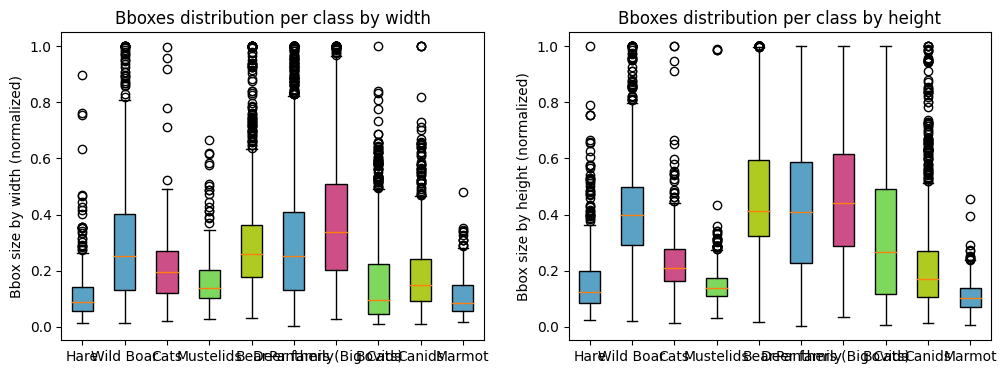

In [8]:
from collections import defaultdict, Counter

# Assuming name2idx is defined elsewhere, e.g., {0: "Hare", 1: "Wild Boar", ...}
# class_to_name = {v: k for k, v in name2idx.items()}

def part_info(df):
    """ Считаем статистики по датасету и рисуем распределение размеров ббоксов по классам. """
    # Parse 'detection' column to extract bbox sizes [w, h] and categories
    df['bbox_sizes'] = df['detection'].apply(
        lambda x: [(float(det.strip().split(' ')[3]), float(det.strip().split(' ')[4]))
                   for det in x.split(';') if len(det.strip().split(' ')) == 5]
    )
    df['categories'] = df['detection'].apply(
        lambda x: [int(det.strip().split(' ')[0])
                   for det in x.split(';') if len(det.strip().split(' ')) == 5]
    )
    
    # Number of bounding boxes per image
    obj_per_img = df['bbox_sizes'].apply(len)
    print(f"Min bboxes per image: {obj_per_img.min()}")
    print(f"Max bboxes per image: {obj_per_img.max()}")
    print(f"Mean bboxes per image: {obj_per_img.mean():.3f}")
    
    # Number of objects per class
    all_categories = df['categories'].sum()  # Flatten list of lists
    counter = Counter(all_categories)
    msg = [f"{idx2name[key]} : {value}" for key, value in counter.items()]
    print("\n\nNumber of objects per class:\n" + "\n".join(msg))
    
    # Collect bbox sizes per class
    bboxes = defaultdict(list)
    for _, row in df.iterrows():
        for size, cls in zip(row['bbox_sizes'], row['categories']):
            bboxes[cls].append(size)
    bboxes = dict(sorted(bboxes.items()))
    
    # Mean bbox size per class (normalized)
    print("\nMean bbox size per class (normalized width, height):")
    for cls, boxes_list in bboxes.items():
        mean_size = np.mean(boxes_list, axis=0)
        print(f"{idx2name[cls]} : {mean_size}")
    
    # Plot box plots for width and height distributions
    print("\n\n")
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    x_boxes = [np.array(val)[:, 0] for val in bboxes.values()]  # Widths
    y_boxes = [np.array(val)[:, 1] for val in bboxes.values()]  # Heights
    labels = [idx2name[cls] for cls in bboxes.keys()]
    colors_list = [color2idx[cls] for cls in bboxes.keys()]
    
    for ax, box, direction in zip(axes, [x_boxes, y_boxes], ["width", "height"]):
        bplot = ax.boxplot(box, patch_artist=True, labels=labels)
        for patch, color in zip(bplot["boxes"], colors_list):
            patch.set_facecolor(np.array(color) / 255)
        ax.set_ylabel(f"Bbox size by {direction} (normalized)")
        ax.set_title(f"Bboxes distribution per class by {direction}")
    plt.show()

box_sizes = part_info(train_df)
box_sizes

Min bboxes per image: 1
Max bboxes per image: 11
Mean bboxes per image: 1.288


Number of objects per class:
Deer family : 2876
Wild Boar : 498
Canids : 447
Marmot : 181
Panthers (Big Cats) : 1085
Bear : 609
Hare : 230
Bovids : 472
Cats : 235
Mustelids : 190

Mean bbox size per class (normalized width, height):
Hare : [0.10918419 0.16235228]
Wild Boar : [0.28784825 0.39576772]
Cats : [0.2185405  0.23334708]
Mustelids : [0.17342384 0.15316467]
Bear : [0.29241576 0.46673866]
Deer family : [0.2880595  0.41885792]
Panthers (Big Cats) : [0.37640808 0.45819622]
Bovids : [0.15121886 0.34410771]
Canids : [0.18802291 0.20987325]
Marmot : [0.10822399 0.11120676]





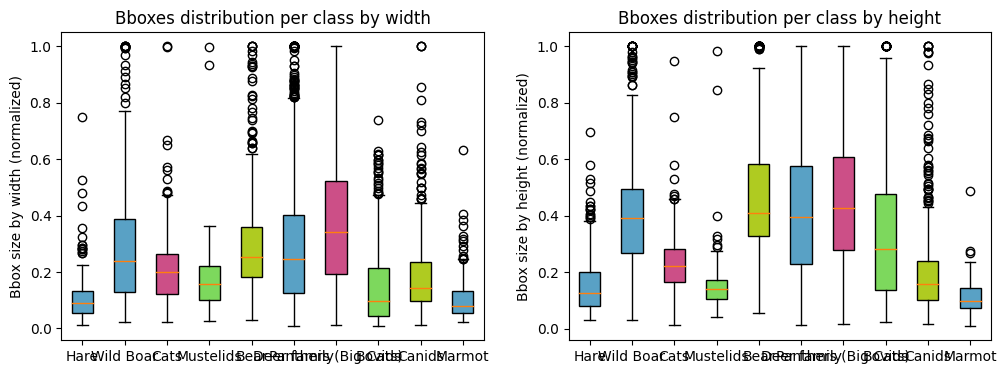

In [9]:
box_sizes = part_info(test_df)

In [11]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, image_dir, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image_name = row['image_name']
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        img = np.array(image)
        height, width = img.shape[:2]
        print(width, height)
        
        # Handle empty or invalid detection strings
        if not row['detection'] or row['detection'].strip() == '':
            continue
        detections = row['detection'].split(';')
        for det in detections:
            parts = det.strip().split(' ')
            if len(parts) != 5:  # Ensure correct format
                continue
            label = int(parts[0])
            cx, cy, w, h = map(float, parts[1:])
            # Convert YOLO format to pixel coordinates
            x_min = (cx - w / 2) * width
            y_min = (cy - h / 2) * height
            box_width = w * width
            box_height = h * height
            class_name = idx2name[label]
            color = color2idx[label % len(color2idx)]
            img = add_bbox(img, [x_min, y_min, box_width, box_height], label=class_name, color=color)
        
        ax.imshow(img)
        ax.set_title(f"Image: {ix}")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

1920 990
1920 990
1920 990
1920 990
1920 990
1920 990


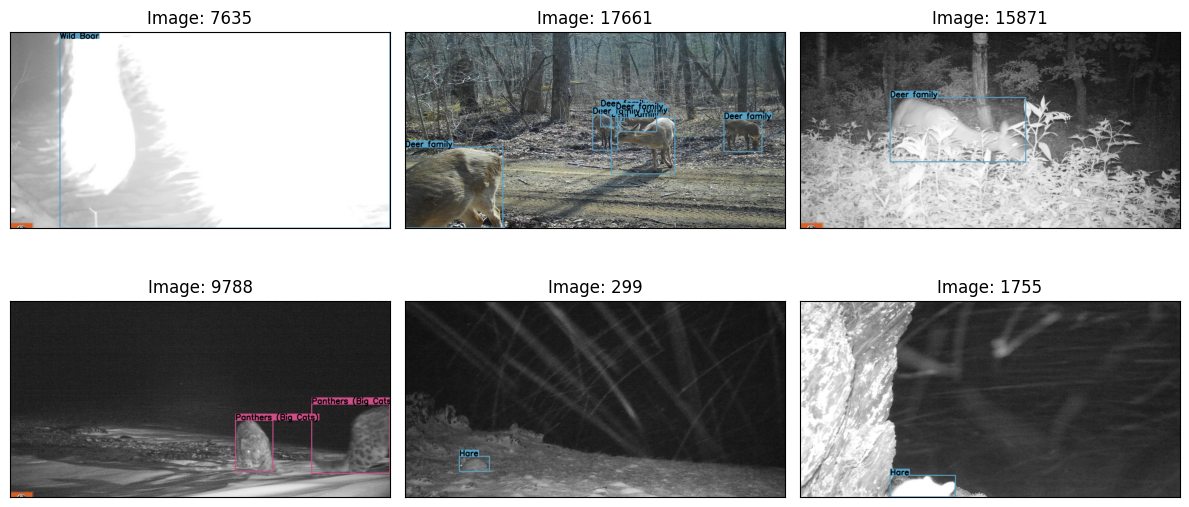

In [12]:
plot_examples(train_split, image_path)

In [12]:
class WATA_Dataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_name = row['image_name']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)

        # Parse YOLO format detections
        detections = row['detection'].split(';')
        boxes = []
        labels = []
        for det in detections:
            parts = det.strip().split(' ')
            label = int(parts[0])  # obj_cls
            cx = float(parts[1])   # center x (normalized)
            cy = float(parts[2])   # center y (normalized)
            w = float(parts[3])    # width (normalized)
            h = float(parts[4])    # height (normalized)
            boxes.append([cx, cy, w, h])
            labels.append(label)

        # Apply transformations if provided
        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        # Convert YOLO format boxes to [x_min, y_min, x_max, y_max] in pixels
        height, width = image.shape[1], image.shape[2]  # After transform, image is a tensor (C, H, W)
        abs_boxes = []
        for box in boxes:
            cx, cy, w, h = box
            x_min = (cx - w / 2) * width
            y_min = (cy - h / 2) * height
            x_max = (cx + w / 2) * width
            y_max = (cy + h / 2) * height
            abs_boxes.append([x_min, y_min, x_max, y_max])

        target = {}
        target['boxes'] = torch.tensor(abs_boxes, dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        target['image_id'] = idx

        return image, target


def collate_fn(batch):
    images = []
    boxes_list = []
    labels_list = []
    
    # Unpack batch and collect images, boxes, and labels
    for image, target in batch:
        images.append(image)
        boxes_list.append(target['boxes'])
        labels_list.append(target['labels'])
    
    # Stack images into a single tensor
    images = torch.stack(images)  # Shape: (batch_size, C, H, W)
    
    # Pad boxes and labels to have the same number of objects
    gt_bboxes_batch = pad_sequence(boxes_list, batch_first=True, padding_value=-1)  # Shape: (batch_size, max_objects, 4)
    gt_classes_batch = pad_sequence(labels_list, batch_first=True, padding_value=-1)  # Shape: (batch_size, max_objects)
    
    return images, gt_bboxes_batch, gt_classes_batch

In [13]:
# Define the transform with resizing
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(height=img_height, width=img_width),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['labels'])
)
test_transform = A.Compose(
    [
        A.Resize(height=img_height, width=img_width),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['labels'])
)

In [14]:
# Instantiate dataset and dataloader
train_dataset = WATA_Dataset(train_df, image_path, transform=train_transform)
test_dataset = WATA_Dataset(test_df, image_path, transform=train_transform)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

Возьмем один батч для демонстрации:

In [15]:
for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

## Вспомогательные функции

In [16]:
def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

In [17]:
def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)
    
    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat

In [18]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']
    
    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes

In [19]:
# # -------------- Visualization utils ----------------

def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
    
    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.cpu().numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1
        
    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')
            
    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')
        
    return fig, ax

## Генерация якорей

In [20]:
def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]
    
    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale
                    
                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)
            
    return anc_base

In [21]:
def gen_anc_centers(out_size):
    out_h, out_w = out_size
    
    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5
    
    return anc_pts_x, anc_pts_y

## Архитектура Faster R-CNN

### Backbone

In [22]:
model = torchvision.models.resnet18(pretrained=True)
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

# run the image through the backbone
out = backbone(img_batch)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h, out_w

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(512, 10, 10)

Проверим насколько уменьшилось изображение

In [23]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

In [24]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [25]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

In [60]:
type(img_batch)

torch.Tensor

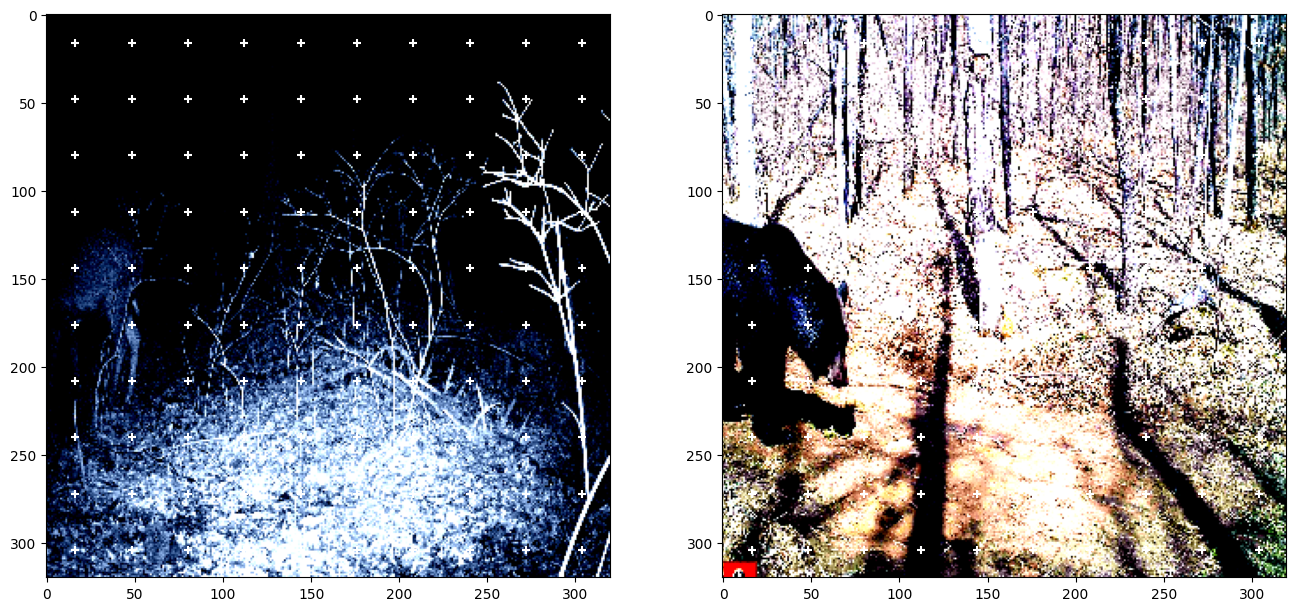

In [26]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

In [27]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [28]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1).to(device)

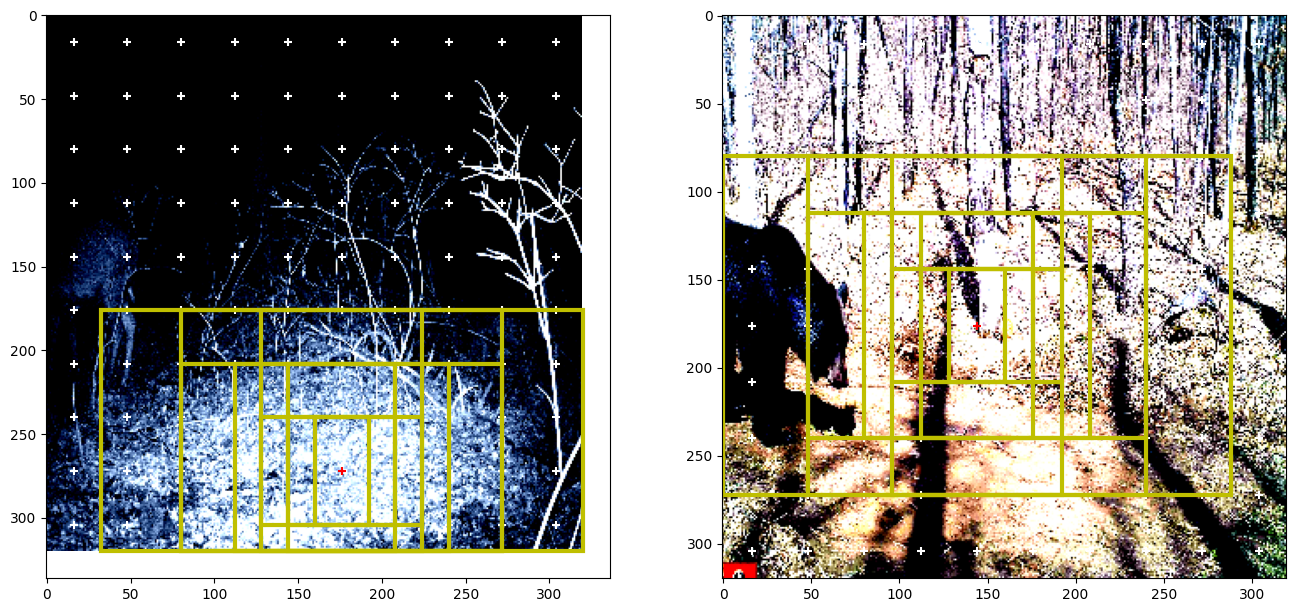

In [29]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [4, 5]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

In [30]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a').to(device)

In [31]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    '''
    Prepare necessary data required for training
    
    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images
        
    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch
    
    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap
    
    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    
    # for every groundtruth bbox in an image, find the iou 
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    
    # get positive anchor boxes
    
    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) 
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]
    
    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    max_iou_per_anc_ind = max_iou_per_anc_ind.to(device)
    
    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]
    
    # get gt classes of the +ve anchor boxes
    
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N).to(device)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]
    
    # get gt bbox coordinates of the +ve anchor boxes
    
    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    
    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    
    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)
    
    # get -ve anchors
    
    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

In [32]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

In [33]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

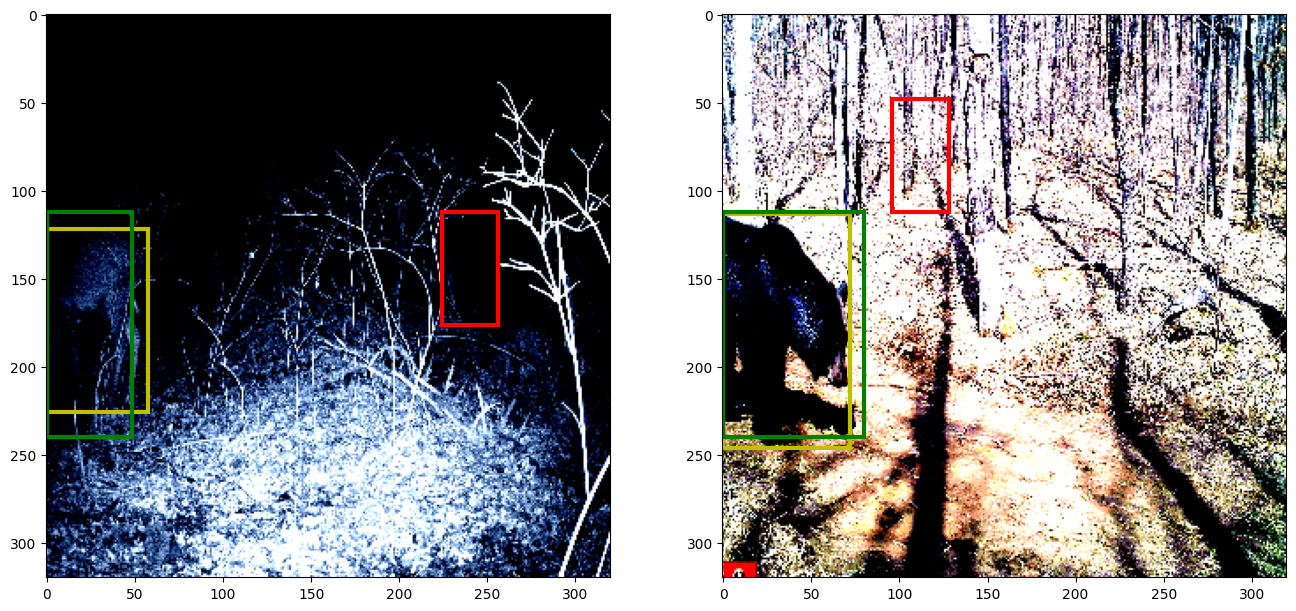

In [34]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [35]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet18(pretrained=True)
        req_layers = list(model.children())[:8]
        self.backbone = nn.Sequential(*req_layers)
        for param in self.backbone.named_parameters():
            param[1].requires_grad = True
        
    def forward(self, img_data):
        return self.backbone(img_data)

### Label Assignment

### Region Proposal Network

In [36]:
def generate_proposals(anchors, offsets):
    anchors = anchors.to(device)
    offsets = offsets.to(device)
    
    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

In [37]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'
            
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)
        
        if mode == 'train': 
            # get conf scores 
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals
            
        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

In [38]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()

        self.out_channels = out_channels
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        
        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        anc_boxes_all = anc_boxes_all.to(device)  # move tensor to device
        
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos

### Classification Stage

In [39]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)

        # Cast to float32 to match fc weights
        roi_out = roi_out.to(dtype=torch.float32)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss
    
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss

## Функции потерь

In [40]:
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))
     
    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size
    
    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

## Построение модели

In [41]:
class EarlyStopping:
    """
    A utility class for early stopping during model training.
    Monitors validation loss to halt training when the model stops improving.

    Attributes:
        patience (int): Number of epochs to wait for improvement before stopping.
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
    """

    def __init__(self, patience: int = 5, delta: float = 0) -> None:
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss: int, model: nn.Module) -> None:
        """
        Update the early stopping criteria based on the validation loss and the current model state.

        Args:
            val_loss (float): The current validation loss.
            model (nn.Module): The model instance to store the state of.

        Returns:
            None
        """
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model: nn.Module) -> None:
        """
        Load the best model state into the specified model.

        Args:
            model (nn.Module): The model instance to load the state into.

        Returns:
            None
        """
        model.load_state_dict(self.best_model_state)

In [42]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size).to(device)

In [43]:
# detector.eval()
# total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
# proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

## Обучение детектора

In [44]:
train_run = Run(repo='/kaggle/working/.aim', experiment='faster_rcnn_training')

In [45]:
import gc
from torch.amp import GradScaler, autocast

def compute_validation_loss(model, val_dataloader, device):
    """
    Compute the average validation loss over the validation dataset.
    
    Args:
        model: The neural network model.
        val_dataloader: DataLoader for the validation dataset.
        device: The device to run the model on (e.g., 'cuda' or 'cpu').
    
    Returns:
        float: The average validation loss.
    """
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    num_batches = 0
    
    with torch.no_grad():  # Disable gradient computation for validation
        for img_batch, gt_bboxes_batch, gt_classes_batch in val_dataloader:
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)
            
            with autocast(device_type='cuda', enabled=True):  # Use mixed precision for validation
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            total_val_loss += loss.item()
            num_batches += 1
            
            # Clear memory
            del img_batch, gt_bboxes_batch, gt_classes_batch
            torch.cuda.empty_cache()
    
    model.train()  # Restore model to training mode
    return total_val_loss / num_batches if num_batches > 0 else float('inf')

def training_loop(model, learning_rate, train_dataloader, val_dataloader, n_epochs, device, run):
    early_stopping = EarlyStopping(patience=10, delta=0.0001)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler('cuda')
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_train_loss = 0
        num_batches = 0
        
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)
            
            optimizer.zero_grad()  # Clear gradients
            with autocast(device_type='cuda', enabled=True):
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_train_loss += loss.item()
            num_batches += 1

            if run is not None:
                run.track(loss.item(), name='batch_loss', step=i, context={'epoch': i})
                run.track(torch.cuda.memory_allocated() / 1024**3, name='memory_usage', step=i, context={'epoch': i})
                run.track(torch.cuda.max_memory_allocated() / 1024**3, name='max_memory', step=i, context={'epoch': i})
            
            # Clear memory
            del img_batch, gt_bboxes_batch, gt_classes_batch
            torch.cuda.empty_cache()
        
        avg_train_loss = total_train_loss / num_batches if num_batches > 0 else float('inf')
        loss_list.append(avg_train_loss)
        
        # Compute validation loss
        avg_val_loss = compute_validation_loss(model, val_dataloader, device)
        
        # Check early stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after epoch {i+1}")
            early_stopping.load_best_model(model)  # Restore the best model state
            break
        
        print(f"Epoch {i+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        gc.collect()
    
    return loss_list

In [46]:
learning_rate = 1e-3
n_epochs = 3

train_run["hparams"] = {
    "backbone": "resnet18",
    "n_classes": n_classes,
    "out_channels": detector.rpn.out_channels,  # From RegionProposalNetwork
    "roi_size": detector.classifier.roi_size,  # From ClassificationModule
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "n_epochs": n_epochs,
    "img_number": len(train_df),
    "img_size": (img_width, img_height),
    "anc_scales": detector.rpn.anc_scales,
    "anc_ratios": detector.rpn.anc_ratios,
    "pos_thresh": detector.rpn.pos_thresh,
    "neg_thresh": detector.rpn.neg_thresh,
}

loss_list = training_loop(
    detector,
    learning_rate,
    train_dataloader,
    test_dataloader,
    n_epochs,
    device,
    run=train_run
)

 33%|███▎      | 1/3 [00:24<00:49, 24.70s/it]

Epoch 1, Train Loss: 25.3277, Val Loss: 162.4233


 67%|██████▋   | 2/3 [00:47<00:23, 23.86s/it]

Epoch 2, Train Loss: 10.8795, Val Loss: 19.6011


100%|██████████| 3/3 [01:11<00:00, 23.80s/it]

Epoch 3, Train Loss: 7.9796, Val Loss: 7.8414


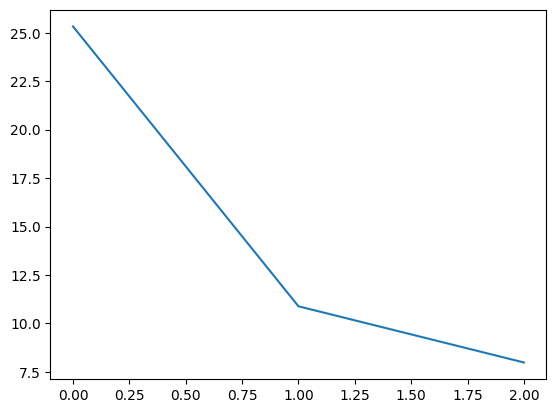

In [47]:
plt.plot(loss_list)

In [48]:
import subprocess
import time

# Start Aim UI server
aim_process = subprocess.Popen(["aim", "up", "--repo=/kaggle/working/.aim", "--host=0.0.0.0", "--port=43801"])
time.sleep(5)
try:
    subprocess.check_output(["curl", "http://localhost:43801"])
    print("Aim UI server is running")
except subprocess.CalledProcessError:
    print("Failed to connect to Aim UI server")
    aim_process.terminate()
    raise

# Set up ngrok tunnel
ngrok.set_auth_token("2zTyWl6eUhKJmqt2Rx1yeJPe2cG_6ZFsmfbnKx5FX7wCrBSFL")
public_url = ngrok.connect(43801, bind_tls=True)
print(f"Aim UI available at: {public_url}")

Сохраним модель

In [49]:
torch.save(detector.state_dict(), "model.pt")

## Инференс

In [50]:
score_threshold = 0.4
nms_threshold = 0.7

inference_run = Run(repo='/kaggle/working/.aim', experiment='faster_rcnn_inference')

inference_run["hparams"] = {
    "backbone": "resnet18",
    "n_classes": n_classes,
    "out_channels": detector.rpn.out_channels,  # From RegionProposalNetwork
    "roi_size": detector.classifier.roi_size,  # From ClassificationModule
    "batch_size": batch_size,
    "img_number": len(train_df),
    "img_size": (img_width, img_height),
    "anc_scales": detector.rpn.anc_scales,
    "anc_ratios": detector.rpn.anc_ratios,
    "pos_thresh": detector.rpn.pos_thresh,
    "neg_thresh": detector.rpn.neg_thresh,
    "nms_thresh": nms_threshold,
    "conf_thresh": score_threshold
}

In [51]:
import time
import torchvision.ops as ops

@torch.no_grad()
def rpn_inference(rpn, images, conf_thresh=0.5, nms_thresh=0.7, run=None):
    start_time = time.time()
    images = images.to(device)
    batch_size = images.size(dim=0)
    with autocast(device_type='cuda', enabled=True):
        feature_map = rpn.feature_extractor(images)
        
        # Generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(rpn.out_h, rpn.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, rpn.anc_scales, rpn.anc_ratios, (rpn.out_h, rpn.out_w))
        anc_base = anc_base.to(dtype=feature_map.dtype)  # Cast to match feature_map
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
        
        # Get confidence scores and offsets
        conf_scores_pred, offsets_pred = rpn.proposal_module(feature_map)
        conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
        offsets_pred = offsets_pred.reshape(batch_size, -1, 4)
        
        # Filter out proposals based on conf threshold and NMS threshold for each image
        proposals_final = []
        conf_scores_final = []
        for i in range(batch_size):
            conf_scores = torch.sigmoid(conf_scores_pred[i])
            offsets = offsets_pred[i]
            anc_boxes = anc_boxes_flat[i]
            proposals = generate_proposals(anc_boxes, offsets)
            proposals = proposals.to(dtype=feature_map.dtype)  # Cast proposals to float16
            # Filter based on confidence threshold
            conf_idx = torch.where(conf_scores >= conf_thresh)[0]
            conf_scores_pos = conf_scores[conf_idx]
            proposals_pos = proposals[conf_idx]
            # Filter based on NMS threshold
            nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
            conf_scores_pos = conf_scores_pos[nms_idx]
            proposals_pos = proposals_pos[nms_idx]
            
            proposals_final.append(proposals_pos)
            conf_scores_final.append(conf_scores_pos)
    
    end_time = time.time()
    if run is not None:
        run.track(end_time - start_time, name='rpn_inference_time')
    return proposals_final, conf_scores_final, feature_map

@torch.no_grad()
def detector_inference(detector, images, conf_thresh=0.5, nms_thresh=0.7, run=None):
    start_time = time.time()
    proposals_final, conf_scores_final, feature_map = rpn_inference(detector.rpn, images, conf_thresh, nms_thresh, run=run)

    cls_scores = detector.classifier(feature_map, proposals_final)
    
    # Convert scores into probability
    cls_probs = F.softmax(cls_scores, dim=-1)
    # Get classes with highest probability
    classes_all = torch.argmax(cls_probs, dim=-1)
    
    classes_final = []
    # Slice classes to map to their corresponding image
    c = 0
    for i in range(len(proposals_final)):
        n_proposals = len(proposals_final[i])
        classes_final.append(classes_all[c:c + n_proposals])
        c += n_proposals
    
    end_time = time.time()
    if run is not None:
        run.track(end_time - start_time, name='detector_inference_time')
    return proposals_final, conf_scores_final, classes_final

In [52]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector_inference(
    detector,
    img_batch,
    conf_thresh=score_threshold,
    nms_thresh=nms_threshold,
    run=inference_run
)

In [53]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

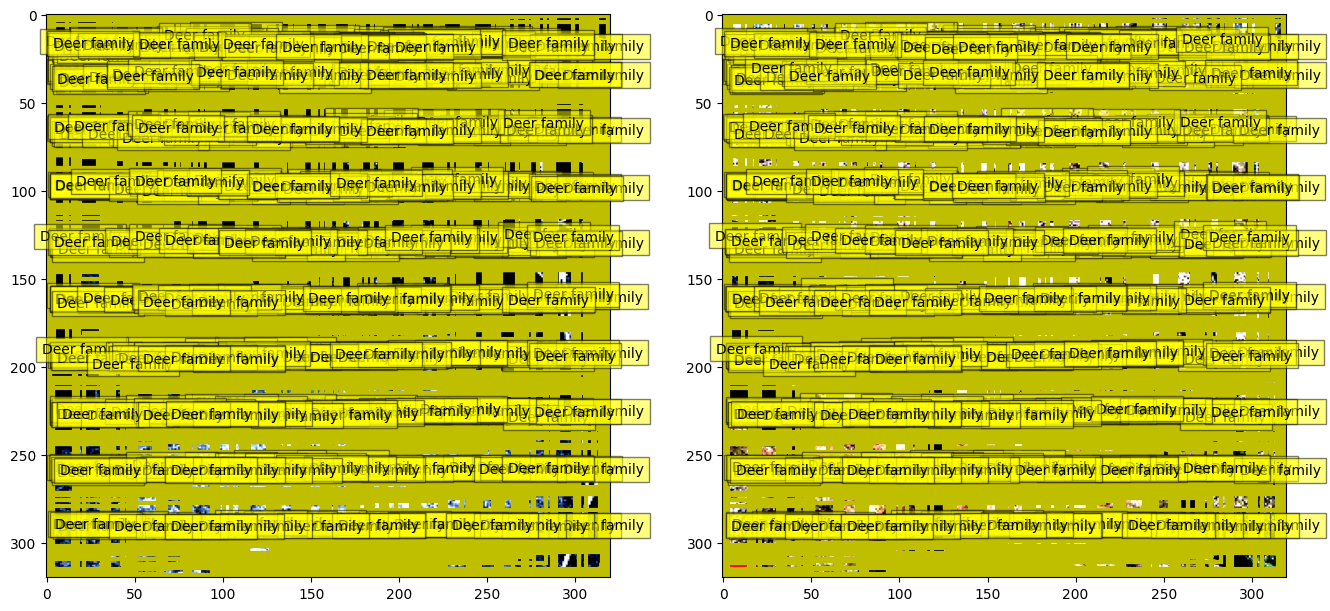

In [54]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
img_batch = img_batch[:2]
fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

## Подсчёт метрик

In [55]:
def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]


test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

In [56]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tqdm import tqdm
import torch
import gc

@torch.no_grad()
def compute_coco_map(model, dataloader, score_threshold=0.01, nms_threshold=0.5, num_classes=4, run=None, device='cuda'):
    """Compute mAP on the COCO dataset."""
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Dataset Evaluation")):
        print(f"Batch {batch_idx}, GPU memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
        images = images.to(device)
        # Validate targets
        for i in range(len(targets)):
            assert isinstance(targets[i]["image_id"], int), f"Invalid image_id in batch {batch_idx}"
            assert targets[i]["boxes"].shape[-1] == 4, f"Invalid boxes shape in batch {batch_idx}"
        
        # Run inference
        predictions = detector_inference(model, images, conf_thresh=score_threshold, nms_thresh=nms_threshold)
        
        # Process predictions and ground truth
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Save predictions in COCO format
            proposals_final, conf_scores_final, classes_final = predictions
            for box, cls, sc in zip(proposals_final[i], classes_final[i], conf_scores_final[i]):  # Index into lists
                detection = {
                    "image_id": int(image_id),
                    "category_id": int(cls.cpu()) + 1,  # Convert tensor to int
                    "bbox": [float(b) for b in box.cpu().numpy()],  # Convert tensor to list of floats
                    "score": float(sc.cpu())  # Convert tensor to float
                }
                all_detections.append(detection)

            # Save ground truth in COCO format
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": int(image_id),
                    "category_id": int(label) + 1,
                    "bbox": [float(b) for b in box],
                    "area": float(box[2] * box[3]),
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1
        
        # Clear memory
        del images, targets, predictions
        torch.cuda.empty_cache()
        gc.collect()

    # Validate COCO inputs
    print(f"Detections: {len(all_detections)}, GT annotations: {len(all_gt_annotations)}")
    for detection in all_detections:
        assert all(k in detection for k in ["image_id", "category_id", "bbox", "score"]), f"Invalid detection: {detection}"
    for gt in all_gt_annotations:
        assert all(k in gt for k in ["id", "image_id", "category_id", "bbox", "area", "iscrowd"]), f"Invalid GT: {gt}"

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)
    print(f"GPU memory after COCO loading: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    print("Starting COCO evaluation")
    coco_eval.evaluate()
    print("COCO evaluate done")
    coco_eval.accumulate()
    print("COCO accumulate done")
    coco_eval.summarize()
    print("COCO summarize done")

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    if run is not None:
        run.track(overall_mAP, name='overall_mAP')

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = idx2name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize()
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap
        if run is not None:
            run.track(ap, name=f'mAP_class_{class_name}')

    # Clear COCO objects to free memory
    del coco_gt, coco_dt, coco_eval
    if 'coco_eval_cat' in locals():
        del coco_eval_cat
    all_detections.clear()
    all_gt_annotations.clear()
    images_info.clear()
    gc.collect()
    torch.cuda.empty_cache()

    print(f"GPU memory after cleanup: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    return overall_mAP, class_maps

In [57]:
compute_coco_map(
    detector,
    test_dataloader,
    score_threshold=score_threshold,
    nms_threshold=nms_threshold,
    num_classes=n_classes,
    run=inference_run
)

Dataset Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Batch 0, GPU memory: 0.12 GB


Dataset Evaluation:   6%|▋         | 1/16 [00:08<02:13,  8.87s/it]

Batch 1, GPU memory: 0.12 GB


Dataset Evaluation:  12%|█▎        | 2/16 [00:11<01:14,  5.32s/it]

Batch 2, GPU memory: 0.12 GB


Dataset Evaluation:  19%|█▉        | 3/16 [00:14<00:53,  4.12s/it]

Batch 3, GPU memory: 0.12 GB


Dataset Evaluation:  25%|██▌       | 4/16 [00:17<00:42,  3.55s/it]

Batch 4, GPU memory: 0.12 GB


Dataset Evaluation:  31%|███▏      | 5/16 [00:19<00:35,  3.25s/it]

Batch 5, GPU memory: 0.12 GB


Dataset Evaluation:  38%|███▊      | 6/16 [00:22<00:30,  3.07s/it]

Batch 6, GPU memory: 0.12 GB


Dataset Evaluation:  44%|████▍     | 7/16 [00:25<00:26,  2.97s/it]

Batch 7, GPU memory: 0.12 GB


Dataset Evaluation:  50%|█████     | 8/16 [00:27<00:23,  2.88s/it]

Batch 8, GPU memory: 0.12 GB


Dataset Evaluation:  56%|█████▋    | 9/16 [00:30<00:19,  2.79s/it]

Batch 9, GPU memory: 0.12 GB


Dataset Evaluation:  62%|██████▎   | 10/16 [00:33<00:16,  2.72s/it]

Batch 10, GPU memory: 0.12 GB


Dataset Evaluation:  69%|██████▉   | 11/16 [00:35<00:13,  2.71s/it]

Batch 11, GPU memory: 0.12 GB


Dataset Evaluation:  75%|███████▌  | 12/16 [00:38<00:10,  2.68s/it]

Batch 12, GPU memory: 0.12 GB


Dataset Evaluation:  81%|████████▏ | 13/16 [00:41<00:07,  2.67s/it]

Batch 13, GPU memory: 0.12 GB


Dataset Evaluation:  88%|████████▊ | 14/16 [00:43<00:05,  2.67s/it]

Batch 14, GPU memory: 0.12 GB


Dataset Evaluation:  94%|█████████▍| 15/16 [00:46<00:02,  2.66s/it]

Batch 15, GPU memory: 0.12 GB


Dataset Evaluation: 100%|██████████| 16/16 [00:48<00:00,  3.02s/it]


Detections: 555663, GT annotations: 1240
creating index...
index created!
Loading and preparing results...
DONE (t=1.66s)
creating index...
index created!
GPU memory after COCO loading: 0.12 GB
Starting COCO evaluation
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
COCO evaluate done
Accumulating evaluation results...
DONE (t=0.70s).
COCO accumulate done
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

KeyError: 10